## Imports

In [1]:
suppressPackageStartupMessages({
    require(Matrix)
    require(Rcpp)
    require(gtools)
    library(sccore)
    library(Seurat)
    library(tidyverse)
    library(ggplot2)
    library(conos)
    library(scDblFinder)
    library(ggthemes)
    library(ggridges)
    library(ggrepel)
    library(purrr)
})

In [268]:
getwd()

[1] "/home/hsarkar/Projects/SpatialContext/Simulation_Notebooks"

In [2]:
fig.size <- function (height, width) {
    options(repr.plot.height = height, repr.plot.width = width)
}

In [3]:
source("../R_library/slide-sim.r")

In [4]:
bulk.data = readRDS('/home/meisl/backup/NASH/Oct.Figures/F4_bulk/data.tmp.rds')

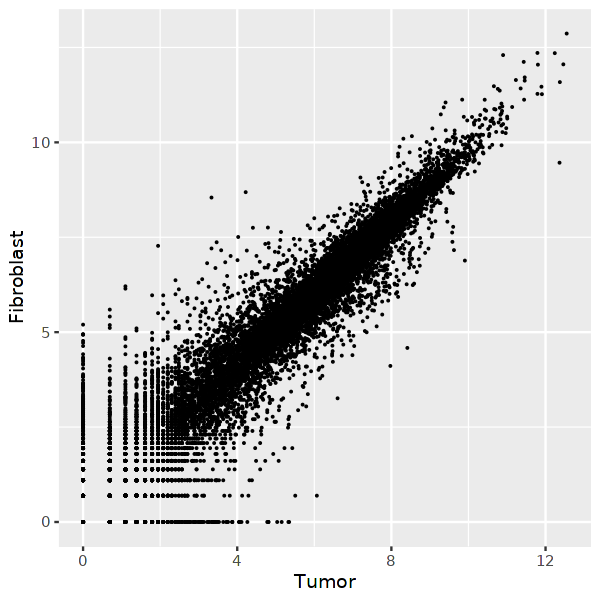

In [5]:
colnames(bulk.data) = c('Tumor', 'Fibroblast')
fig.size(5,5)
ggplot(log(bulk.data+1), aes(x=Tumor, y = Fibroblast)) + 
    geom_point(size=0.05)

In [42]:
bulk.data = bulk.data[rowSums(bulk.data) != 0,]

In [43]:
devi = abs(bulk.data$Tumor - mean(bulk.data$Tumor))
names(devi) = rownames(bulk.data)

In [44]:
devi %>% sort(decreasing=TRUE) %>% head(10) %>% names

[1] "FN1"      "SERPINE1" "ACTB"     "MMP1"     "EEF1A1"   "ACTG1"   
 [7] "GREM1"    "MT-CO1"   "VIM"      "COL1A2"

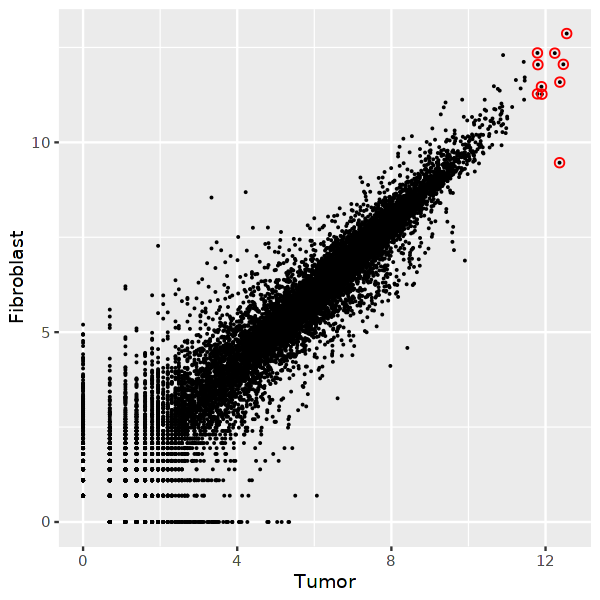

In [45]:
df = bulk.data
df = log(df+1)
red.markers = devi %>% 
    sort(decreasing=TRUE) %>% 
    head(10) %>% 
    names

ggplot(df, aes(x=Tumor, y = Fibroblast)) +
    geom_point(size=0.05) +
    geom_point(data=df[ red.markers ,],
                    pch=21, 
               fill=NA, 
               size=2, 
               colour="red", 
               stroke=0.6,
               na.rm=TRUE)

In [46]:
quantile(bulk.data$Fibroblast, p = seq(0,1,0.1))

0%    10%    20%    30%    40%    50%    60%    70%    80%    90%   100% 
     0      1      3     16     76    213    418    731   1262   2524 386910

In [74]:
simulate.de.genes = function(
    profile,
    n.genes = 100,
    lower.q.range = c(0.4,0.5),
    upper.q.range = c(0.7,0.8),
    upper.cutoff = c(10,5),
    lower.cutoff = c(-10,-5),
    upregulate = TRUE,
    downregulate = TRUE
){
    n.genes.up <- n.genes.down <- round(n.genes/2)
    eq.lower <- quantile(profile, p = lower.q.range)
    eq.upper <- quantile(profile, p = upper.q.range)
    gns <- list(high = which( (profile >= eq.lower[1] & profile <= eq.lower[2]) ), 
                low = which( (profile >= eq.upper[1] & profile <= eq.upper[2]) )
               )
    
    # get delta values
    delta = rcauchy(10000, scale = 5)
    delta.up = delta[delta < upper.cutoff[1] & delta > upper.cutoff[2]]
    delta.down = delta[delta > lower.cutoff[1] & delta < lower.cutoff[2]]
    n.genes.up = min(n.genes.up, length( gns$high ), length( delta.up ))
    n.genes.down = min(n.genes.down, length( gns$low ), length( delta.down ))
    gns = list(
        high = sample( gns$high, n.genes.up ),
        low = sample( gns$low, n.genes.down )
    )
    
    # down regulate some highly expressed genes
    # up regulate some lowly expressed genes
    mp = profile
    mp[gns$high] = as.integer(mp[gns$high] * (2**sample(delta.down,n.genes.up)))
    mp[gns$low] = as.integer(mp[gns$low] * (2**sample(delta.up,n.genes.down)))
    
    cgi <- which(mp!=profile);
    df <- data.frame(cgi,
                   delta=(mp-profile)[cgi]/sum(profile)*1e3,
                   M=log2(mp[cgi]+1)-log2(profile[cgi]+1),
                   row.names=names(profile)[cgi]
                  )
    return(list(profile=mp,altered.genes=df))
}

In [93]:
profile = bulk.data[,'Fibroblast']
names(profile) = rownames(bulk.data)
shifted.exp.fibro = simulate.expression.shift(
    profile,
    q = 0.4
)

simulate.de.fibro = simulate.de.genes(
    profile,
    upper.cutoff = c(8,5),
    lower.cutoff = c(-7,-5)
)

  60%   40% 
488.6 123.4 


In [203]:
source('../R_library/mix_cells.R')
introduce.shift = function(qv, q){
    qv.nz = qv[qv > 0]
    eq = quantile(qv.nz, p = q)
    gns = list(
        low = which(qv >= eq[1] & qv <= eq[2]) %>% names,
        high =  which(qv >= eq[3] & qv <= eq[4]) %>% names
    )
    
    swaps <- data.frame(source=c(),target=c());
    n.genes <- 50
    swaps <- rbind(swaps, 
          data.frame(target=sample(gns$low, n.genes), 
          source=sample(gns$high, n.genes))
    )
    swaps <- rbind(swaps, 
          data.frame(target=sample(gns$high, n.genes), 
          source=sample(gns$low, n.genes))
    )
    
    shifted.exp = simulate.expression.shift(
        profile,
        swaps = swaps
    )
    
    genes.shifted = shifted.exp$altered.genes$cgi

    shifted.profile = shifted.exp$profile
    
    shifted.profile[-genes.shifted] = as.integer(
        shifted.profile[-genes.shifted] *
        2**rnorm(length(shifted.profile)-n.genes*2,0,0.5)
        #2**rcauchy(length(shifted.profile), scale = 5)
        #(2 ** sample(delta, length(shifted.profile), replace = T))
    )
    shifted.profile[genes.shifted] = as.integer(
        shifted.profile[genes.shifted] *
        2**rnorm(n.genes*2,0,2)
    )
    names(shifted.profile) = names(shifted.exp$profile)
    return(
        list(
            alter.gene = shifted.exp$altered.genes,
            profile = shifted.profile
        )
    )
    
}

In [206]:
qv = bulk.data$Fibroblast
names(qv) = rownames(bulk.data)
q = c(0.2,0.4,0.7,0.8)
shifted.exp.fibro = introduce.shift(qv, q)
qv = bulk.data$Tumor
names(qv) = rownames(bulk.data)
shifted.exp.tumor = introduce.shift(qv, q)

In [240]:
simulate.de.control = as(
    as.matrix(bulk.data),
    "sparseMatrix"
)
    
simulate.de.treatment = as(
    as.matrix(cbind(
    Tumor = shifted.exp.tumor$profile,
    Fibroblast = shifted.exp.fibro$profile
    )),
    "sparseMatrix"
)

In [242]:
simulate.de.control[1:3,]

3 x 2 sparse Matrix of class "dgCMatrix"
     Tumor Fibroblast
A1BG    54         55
A1CF     1          .
A2M    314        869

In [243]:
simulate.de.treatment[1:3,1:2]

3 x 2 sparse Matrix of class "dgCMatrix"
     Tumor Fibroblast
A1BG    70         56
A1CF     .          .
A2M    914        682

In [244]:
nbeads = 1e4
puck1 = slide.sim(
    simulate.de.control, 
    nbeads=nbeads, 
    cell.group.proportions = c("Tumor"=0.3,"Fibroblast"=0.7),
    mixing.alpha = c(3,1)
)

puck2 = slide.sim(
    simulate.de.treatment, 
    nbeads=nbeads, 
    cell.group.proportions = c("Tumor"=0.8,"Fibroblast"=0.2),
    mixing.alpha = c(3,1)
)


     Tumor Fibroblast 
       0.3        0.7 
     Tumor Fibroblast 
       0.8        0.2 


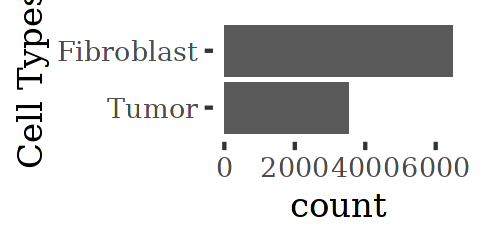

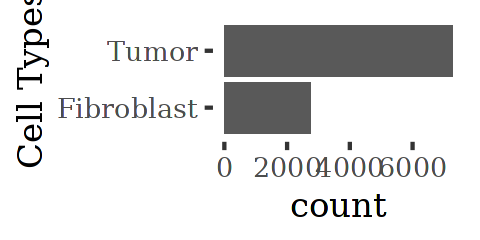

In [245]:
fig.size(2,4)
mix.mat = t(puck1$bead.mixtures)
colnames(mix.mat)[max.col(mix.mat)] %>%
    table %>%
    data.frame %>%
    rename(.='Var1') %>%
    ggplot(aes(y=reorder(Var1,Freq))) +
    geom_bar(aes(weight=Freq)) +
    ylab('Cell Types') +
    theme_tufte(base_size = 20)

fig.size(2,4)
mix.mat = t(puck2$bead.mixtures)
colnames(mix.mat)[max.col(mix.mat)] %>%
    table %>%
    data.frame %>%
    rename(.='Var1') %>%
    ggplot(aes(y=reorder(Var1,Freq))) +
    geom_bar(aes(weight=Freq)) +
    ylab('Cell Types') +
    theme_tufte(base_size = 20)

In [249]:
source("../R_library/slide-sim.r")
benign.count = puck1$bead.counts
mix.mat = t(puck1$bead.mixtures)
benign.annot = as.factor(
    colnames(mix.mat)[max.col(mix.mat)]
)
names(benign.annot) = rownames(mix.mat)
benign.profile = collapse.clusters(
    benign.count,
    benign.annot
)

# -----------------------------------------
tumor.count = puck2$bead.counts
mix.mat = t(puck2$bead.mixtures)
tumor.annot = as.factor(
    colnames(mix.mat)[max.col(mix.mat)]
)
names(tumor.annot) = rownames(mix.mat)
tumor.profile = collapse.clusters(
    tumor.count,
    tumor.annot
)
# ---------------------------------------

colnames(tumor.profile) = paste(
    colnames(tumor.profile),
    'Tumor',
    sep = '_'
)
colnames(benign.profile) = paste(
    colnames(benign.profile),
    'Non_Tumor',
    sep = '_'
)

combined = cbind(
    tumor.profile,
    benign.profile
)

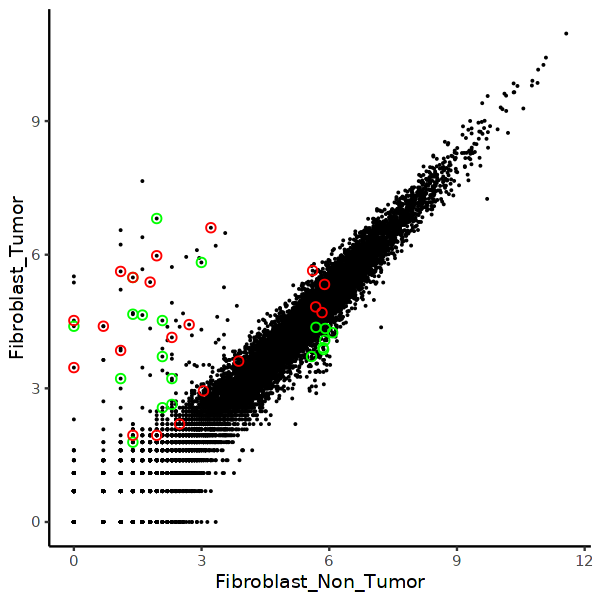

In [258]:
df = data.frame(combined)
fig.size(5,5)

df = log(df+1)
red.markers = shifted.exp.tumor$alter.gene %>% 
    rownames %>% head(20)

green.markers = shifted.exp.fibro$alter.gene %>%
    rownames %>% head(20)


ggplot(df, aes(x=Fibroblast_Non_Tumor, y = Fibroblast_Tumor)) + 
    geom_point(size=0.05) +
    theme_classic() + 
    geom_point(data=df[ green.markers ,],
                    pch=21, 
               fill=NA, 
               size=2, 
               colour="green", 
               stroke=0.6,
               na.rm=TRUE) +
    geom_point(data=df[ red.markers ,],
                    pch=21, 
               fill=NA, 
               size=2, 
               colour="red", 
               stroke=0.6,
               na.rm=TRUE)

In [259]:
get.de.mat.2 <- function(
    profile,
    target1,
    target2,
    gene.scale.function=sqrt,
    library.size.scale=1e6){
    
    p <- profile
    gene.scaling <- gene.scale.function(
        rowSums(p)
    )/rowSums(p)
    p <- t(t(p)/colSums(p)*library.size.scale)*gene.scaling
    m <- lm.fit( 
        as.matrix(p[,colnames(p) != target1]), 
        p[,target1] 
    )
    #par(mar=c(12,3.5,0.5,0.5),mgp=c(2,0.65,0))
    #barplot(sort(m$coefficients),las=2)
    pos <- names(m$coefficients[m$coefficients>0])
    neg <- names(m$coefficients[!m$coefficients>0])
    
    p <- profile
    libsizes <- colSums(p)
    t1ap <- p[,target1] + 
        colSums(t(p[,neg])/libsizes[neg]*libsizes[target1]*(-1*m$coefficients[neg]))
    t2ap <- colSums(t(p[,pos])/libsizes[pos]*libsizes[target2]*(m$coefficients[pos]))
    mat <- cbind(t2ap, t1ap)
    colnames(mat) <- c('ntp','tp')
    storage.mode(mat) <- 'integer'
    mat
    
}

In [260]:
combined = combined[rowSums(combined) != 0,]

In [261]:
target = 'Fibroblast'
target1 = paste(target, 'Tumor', sep = '_')
target2 = paste(target, 'Non_Tumor', sep = '_')

res = get.de.mat.2(
    as.matrix(combined),
    target1,
    target2,
    library.size.scale=1e4
)

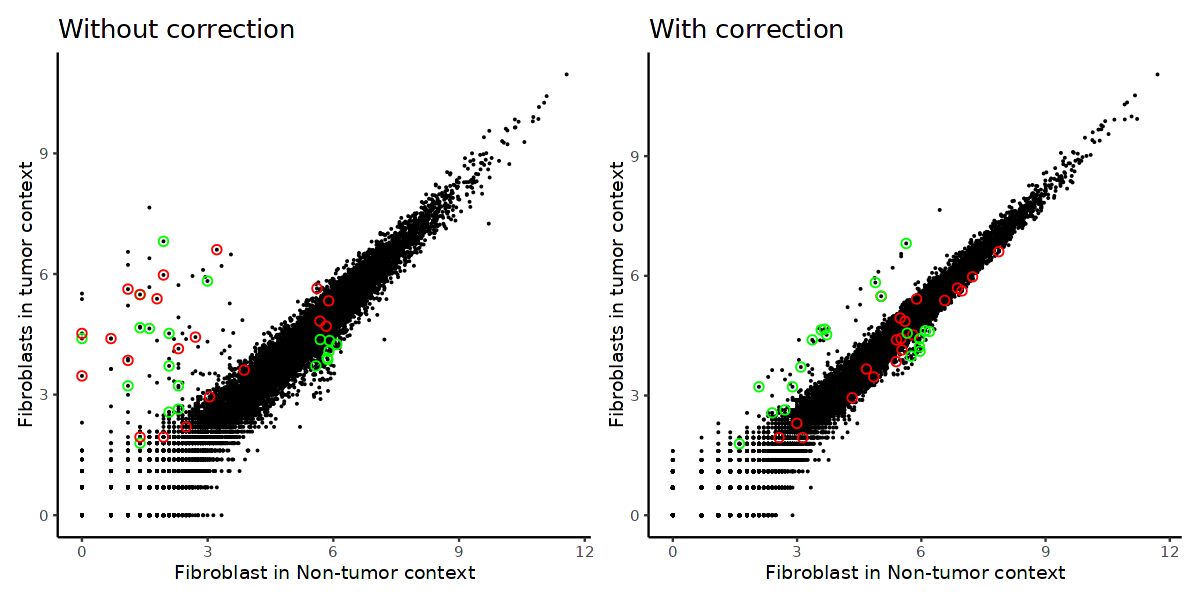

In [267]:
df = data.frame(res)
df = log(df+1)

fig.size(5,5)
p1 = ggplot(df, aes(x=ntp,y=tp)) + 
    geom_point(size=0.05) +
     labs(x='Fibroblast in Non-tumor context', y='Fibroblasts in tumor context') + 
    #geom_abline(slope = 1, intercept = 0, linetype="dashed")+
#     geom_abline(slope = 1, intercept = 0, linetype="dashed") +
#     geom_abline(slope = 1, intercept = 1, linetype="dashed") +
#     geom_abline(slope = 1, intercept = -1, linetype="dashed") +
    geom_point(data=df[ red.markers ,],
                    pch=21, 
               fill=NA, 
               size=2, 
               colour="red", 
               stroke=0.6,
               na.rm=TRUE) +
    geom_point(data=df[ green.markers ,],
                    pch=21, 
               fill=NA, 
               size=2, 
               colour="green", 
               stroke=0.6,
               na.rm=TRUE) +
    theme_classic() +
    ggtitle("With correction") +
    theme(plot.title = element_text(size = 15))

df = data.frame(combined)
df = log(df+1)
p2 = ggplot(df, aes(x=Fibroblast_Non_Tumor, y = Fibroblast_Tumor)) + 
    labs(x='Fibroblast in Non-tumor context', y='Fibroblasts in tumor context') + 
    geom_point(size=0.05) +
    theme_classic() + 
#     geom_abline(slope = 1, intercept = 0, linetype="dashed") +
#     geom_abline(slope = 1, intercept = 1, linetype="dashed") +
#     geom_abline(slope = 1, intercept = -1, linetype="dashed") +
    geom_point(data=df[ green.markers ,],
                    pch=21, 
               fill=NA, 
               size=2, 
               colour="green", 
               stroke=0.6,
               na.rm=TRUE) +
    geom_point(data=df[ red.markers ,],
                    pch=21, 
               fill=NA, 
               size=2, 
               colour="red", 
               stroke=0.6,
               na.rm=TRUE)+
    ggtitle("Without correction") +
    theme(plot.title = element_text(size = 15))

fig.size(5,10)
p2 + p1